## Assignment 10
### This notebook uses tensorflow 2
### Gradcam 
1. Implement gradcam using imgnet VGG16 for 3 conv_layer from the last
2. Plot the gradcam output on Tony Stark image to find sunglass

In [1]:
# install tf2
!pip install tensorflow-gpu

     |████████████████████████████████| 380.8MB 75kB/s 
     |████████████████████████████████| 3.8MB 31.4MB/s 
     |████████████████████████████████| 450kB 44.7MB/s 
ERROR: tensorflow 1.15.0rc3 has requirement tensorboard<1.16.0,>=1.15.0, but you'll have tensorboard 2.0.0 which is incompatible.
ERROR: tensorflow 1.15.0rc3 has requirement tensorflow-estimator==1.15.1, but you'll have tensorflow-estimator 2.0.0 which is incompatible.
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1


In [3]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as tfk
from tensorflow.keras import backend as K
import cv2
from skimage import io
from google.colab.patches import cv2_imshow
from matplotlib import  pyplot as plt
print(tf.__version__)

2.0.0


In [4]:
# Load pretrained vgg16 model
model = tfk.applications.vgg16.VGG16(weights="imagenet")
model.summary()

553467904/553467096 [==============================] - 7s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
____________________________________________________________

In [0]:
def gradCam(img_tensors,model,conv_layer_name):
  preds = model.predict(img_tensors)
  class_idx = np.argmax(preds[0])
  class_output = model.output[:, class_idx]
  last_conv_layer = model.get_layer(conv_layer_name)

  heatmap_model = tfk.models.Model([model.input], [last_conv_layer.output, model.output])
  with tf.GradientTape() as gtape:
      conv_output, predictions = heatmap_model(img_tensors)
      loss = predictions[:, np.argmax(predictions[0])]
      grads = gtape.gradient(loss, conv_output)
      pooled_grads = K.mean(grads, axis=(0, 1, 2))
    
  heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_output), axis=-1)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)
  heatmap = np.squeeze(heatmap)
  return heatmap

def plotHeatMap(heatmap,img_test):
  img_test = cv2.resize(img_test,(400,400))
  heatmap = cv2.resize(heatmap, (img_test.shape[1], img_test.shape[0]))
  heatmap = np.uint8(255 * heatmap)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  superimposed_img = cv2.addWeighted(img_test, 0.5, heatmap, 0.5, 0)
  cv2_imshow(img_test)
  cv2_imshow(superimposed_img)

In [0]:
url = "https://i.ytimg.com/vi/8K4ZwA2nQqI/hqdefault.jpg" #@param {type:"string"}
img_tensor_original = io.imread(url) 
img_tensor = cv2.resize(img_tensor_original, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
x = tfk.preprocessing.image.img_to_array(img_tensor)
x = np.expand_dims(x, axis=0)
x = tfk.applications.vgg16.preprocess_input(x)

In [10]:
preds = model.predict(x)
print('Predicted Class:', tfk.applications.vgg16.decode_predictions(preds, top=1))

Predicted Class: [[('n03452741', 'grand_piano', 0.68241185)]]


### Grad CAM output for "block5_conv3", "block5_conv2", "block5_conv1"

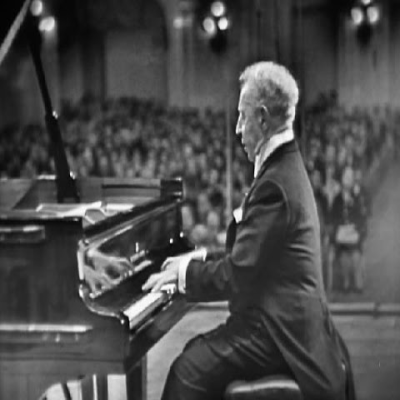

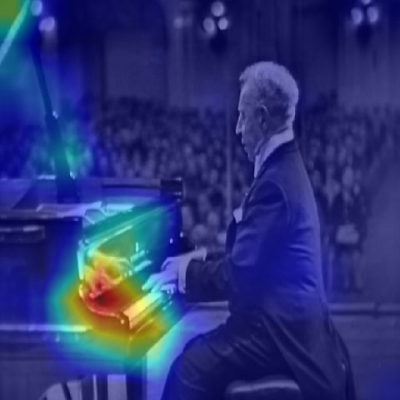

In [11]:
heatmap = gradCam(x,model,"block5_conv3")
plotHeatMap(heatmap,img_tensor_original)

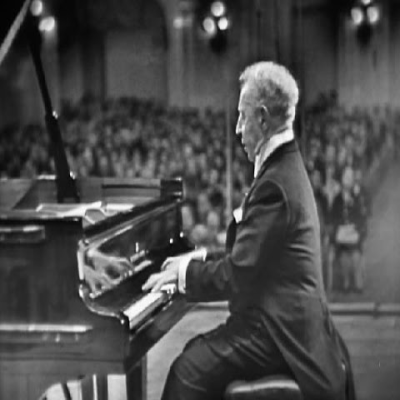

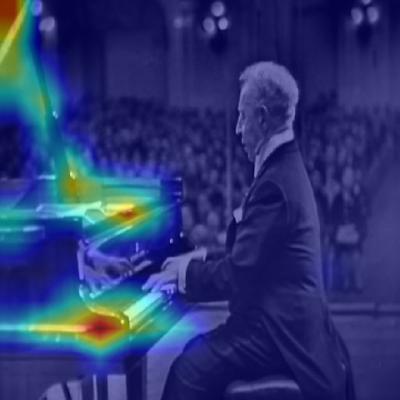

In [12]:
heatmap = gradCam(x,model,"block5_conv2")
plotHeatMap(heatmap,img_tensor_original)

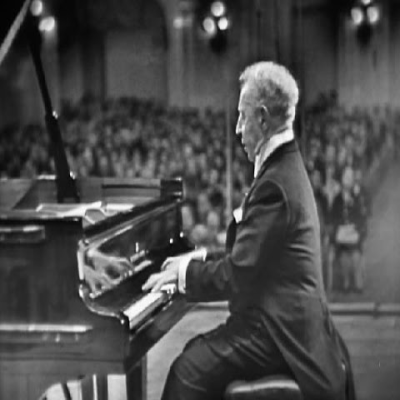

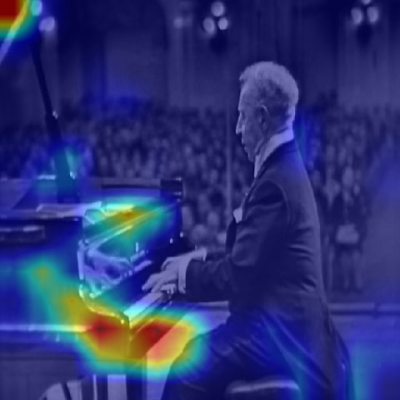

In [13]:
heatmap = gradCam(x,model,"block5_conv1")
plotHeatMap(heatmap,img_tensor_original)

### Find sunglass in the image

In [109]:
!wget https://media.karousell.com/media/photos/products/2018/08/20/16_scale_tony_stark_avenger3_headscrupt_with_glasses_1534759826_e79b0cf4.jpg

--2019-10-13 09:43:37--  https://media.karousell.com/media/photos/products/2018/08/20/16_scale_tony_stark_avenger3_headscrupt_with_glasses_1534759826_e79b0cf4.jpg
Resolving media.karousell.com (media.karousell.com)... 190.93.245.83, 190.93.247.83, 190.93.246.83, ...
Connecting to media.karousell.com (media.karousell.com)|190.93.245.83|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 58670 (57K) [image/jpeg]
Saving to: ‘16_scale_tony_stark_avenger3_headscrupt_with_glasses_1534759826_e79b0cf4.jpg.1’

16_scale_tony_stark 100%[===================>]  57.29K  --.-KB/s    in 0.01s   

2019-10-13 09:43:37 (4.86 MB/s) - ‘16_scale_tony_stark_avenger3_headscrupt_with_glasses_1534759826_e79b0cf4.jpg.1’ saved [58670/58670]



In [110]:
url = "16_scale_tony_stark_avenger3_headscrupt_with_glasses_1534759826_e79b0cf4.jpg" #@param {type:"string"}
stark = io.imread(url)
img_tensor = cv2.resize(stark, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
x = tfk.preprocessing.image.img_to_array(img_tensor)
print(x.shape)
x = np.expand_dims(x, axis=0)
x = tfk.applications.vgg16.preprocess_input(x)

(224, 224, 3)


In [116]:
preds = model.predict(x)
print('Predicted Class:', decode_predictions(preds, top=1))

Predicted Class: [[('n04356056', 'sunglasses', 0.3326374)]]


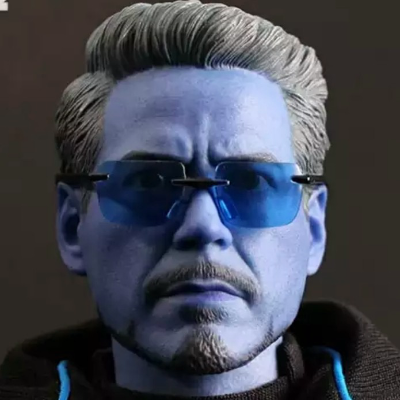

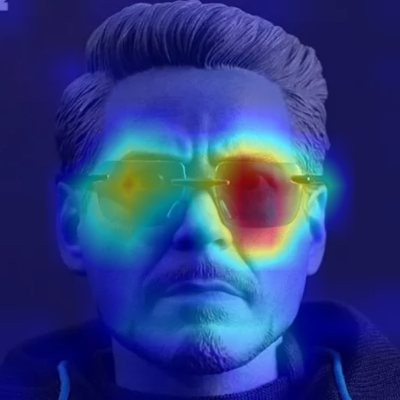

In [113]:
heatmap = gradCam(x,model,"block5_conv3")
plotHeatMap(heatmap,stark)